<a href="https://colab.research.google.com/github/mxykb/413CW1/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
125/125 [==============================] - 8s 50ms/step - loss: 0.2369 - accuracy: 0.9187
Epoch 2/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0598 - accuracy: 0.9798
Epoch 3/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0478 - accuracy: 0.9857
Epoch 4/100
125/125 [==============================] - 6s 51ms/step - loss: 0.0502 - accuracy: 0.9837
Epoch 5/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0447 - accuracy: 0.9857
Epoch 6/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0465 - accuracy: 0.9872
Epoch 7/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0360 - accuracy: 0.9880
Epoch 8/100
125/125 [==============================] - 6s 50ms/step - loss: 0.0441 - accuracy: 0.9864
Epoch 9/100
125/125 [==============================] - 6s 51ms/step - loss: 0.0392 - accuracy: 0.9882
Epoch 10/100
125/125 [==============================] - 6s 50ms/step - loss: 0.037

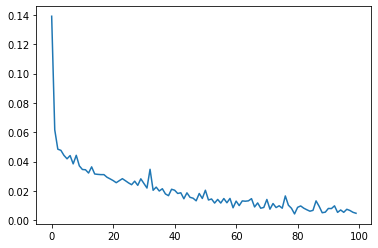

accuracy: 0.991 
 precision: 0.9910389583969078 
 recall: 0.991 
 F1 : 0.9909942857142857


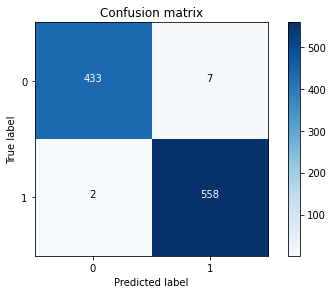

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 13 10:12:57 2021

@author: 79244
"""

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import pywt
import math
import numpy as np
import pandas as pd
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from keras import optimizers
from keras.layers import Dense, Dropout
import itertools
from keras.layers import Activation
from keras.callbacks import TensorBoard

def score(y_test,predictions):
    accuracy = metrics.accuracy_score(y_test, predictions)
    recall = metrics.recall_score(y_test, predictions, average="weighted")
    precision = metrics.precision_score(y_test, predictions, average="weighted")
    F1 = metrics.f1_score(y_test, predictions, average="weighted")  
    print("accuracy:",  accuracy, '\n', "precision:", precision, '\n', "recall:", recall, '\n', "F1 :",  F1)
    return accuracy,precision,recall,F1

def plot_confusion_matrix(cm, classes, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    The function prints and plots the confusion matrix
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)#set colour map from deep to light
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) #The lables of the cluster
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
ecg = raw_data[:, 0:-1]

def denoise(ecg):
    index=[]
    data=[]
    coffs=[]
    
    for i in range(len(ecg)-1):
        X=float(i)
        Y=float(ecg[i])
        index.append(X)
        data.append(Y)
    #create wavelet object and define parameters
    w=pywt.Wavelet('db8')#choose Daubechies8 wavelet
    maxlev=pywt.dwt_max_level(len(data),w.dec_len)
    
    threshold=0  #Threshold for filtering
    
    #Decompose into wavelet components,to the level selected:
    coffs=pywt.wavedec(data,'db8',level=maxlev) #Wavelet decomposition of signals
    
    for i in range(1,len(coffs)):
        coffs[i]=pywt.threshold(coffs[i],threshold*max(coffs[i]))
    
    datarec=pywt.waverec(coffs,'db8')#Wavelet reconstruction of signals
    return np.array(datarec)

denoiseData=np.array([])

min_val = tf.reduce_min(ecg)
max_val = tf.reduce_max(ecg)
ecg = (ecg - min_val) / (max_val - min_val)

for ecgdata in ecg:
    if(len(denoiseData) == 0):
        denoiseData = denoise(ecgdata)
    else:
        denoiseData = np.vstack((denoiseData,denoise(ecgdata)))

train_data, test_data, train_labels, test_labels = train_test_split(denoiseData, labels, test_size=0.2, random_state=21)


X = train_data
y = train_labels

digits = 2
examples = y.shape[0]
y = y.reshape(1, examples)
Y = np.eye(digits)[y.astype('int32')]
Y = Y.T.reshape(digits, examples).T


X2 = test_data
y2 = test_labels

examples = y2.shape[0]
y2 = y2.reshape(1, examples)
Y2 = np.eye(digits)[y2.astype('int32')]
Y2 = Y2.T.reshape(digits, examples).T

timesteps = 140  # Length of your sequences
input_dim = 1
latent_dim = 64

inputs = keras.Input(shape=(timesteps, input_dim))
encoded = keras.layers.LSTM(latent_dim)(inputs)

model_lstmAE_encoder = keras.Model(inputs, encoded)

model = keras.Sequential()
model.add(model_lstmAE_encoder.layers[0])
model.add(model_lstmAE_encoder.layers[1])

model.add(keras.layers.Dense(2, activation='softmax'))
#
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
X = X[...,None]
X2 = X2[...,None]
model.fit(X, Y, epochs=100, batch_size=32)
plt.plot(model.history.history["loss"])
plt.show()
predict = model.predict(X2)
predict = np.argmax(predict, axis=1)
Y2= np.argmax(Y2, axis=1)
cnf_matrix = confusion_matrix(Y2, predict)#create confusion matrix
accuracy1,precision1,recall1,f1 = score(Y2,predict)#calculate the score of the model
class_names=[0,1]
plt.figure#plot the confusion matrix
plot_confusion_matrix(cnf_matrix,classes=class_names, title="Confusion matrix")
plt.show()

In [ ]:
print(model.history.history.keys())

dict_keys([])
